# Solver comparison

In this tutorial, we demonstrate how to compare geostatistical solvers using GeoStats.jl. This feature addresses a recurrent, sometimes underestimated, issue in the geostatistics community: the absence of scientific methods and software for rigorous selection of solvers and parameter sets.

As we will see, the ability to manipulate solvers as first-class objects can save us from exhausting, manual trial and error, and can definitely help us make better use of our time on a critical project with many time constraints.

Before we proceed, please install the following packages:

In [1]:
for pkg in ["GeoStats", "InverseDistanceWeighting", "Plots", "PyPlot"]
    Pkg.add(pkg)
end

# make sure this tutorial is reproducible
srand(2017);

INFO: Package GeoStats is already installed
INFO: Package InverseDistanceWeighting is already installed
INFO: Package Plots is already installed
INFO: Package PyPlot is already installed


## Problem definition

We start by creating a simple 2D estimation problem based on a given data set:

In [2]:
using GeoStats

geodata = readtable("data/porosity.tsv", coordnames=[:x,:y])
grid = bounding_grid(geodata, [100,100])
problem = EstimationProblem(geodata, grid, :porosity)

2D EstimationProblem
  data:      500×3 GeoDataFrame (x and y)
  domain:    100×100 RegularGrid{Float64,2}
  variables: porosity (Float64)

Let's suppose that we want to compare Kriging and inverse distance weighting (a.k.a. IDW) on this problem. Suppose that we are also interested in comparing different variogram models in Kriging. We define the solvers:

In [3]:
using InverseDistanceWeighting

solver₁ = Kriging(:porosity => @NT(variogram=ExponentialVariogram(range=40.)))
solver₂ = Kriging(:porosity => @NT(variogram=SphericalVariogram(range=40.)))
solver₃ = InvDistWeight()

solvers = [solver₁, solver₂, solver₃]

3-element Array{GeoStatsBase.AbstractEstimationSolver,1}:
 GeoStats.Kriging                      
 GeoStats.Kriging                      
 InverseDistanceWeighting.InvDistWeight

and proceed to the comparisons.

## Visual comparison

Visual comparisons can be useful for quickly pruning solver/parameter combinations:


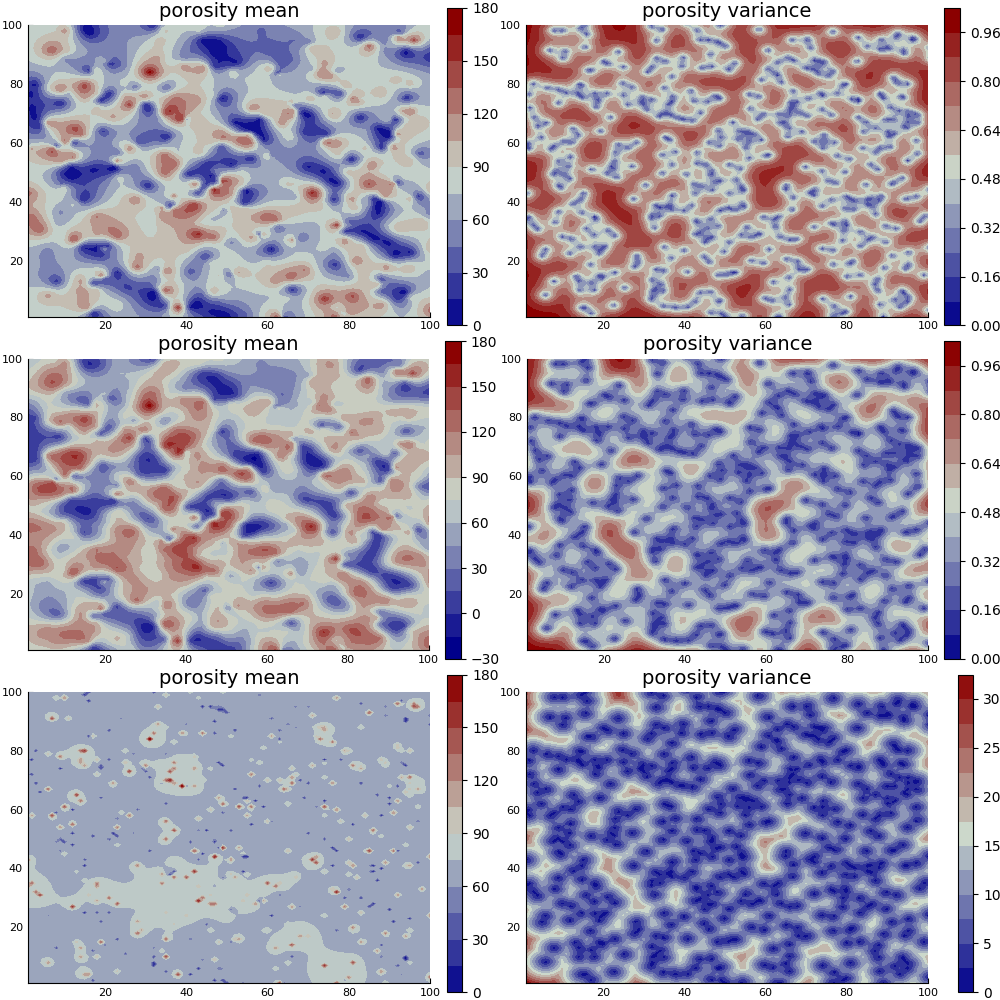

In [4]:
using Plots; pyplot(size=(1000,1000))

compare(solvers, problem, VisualComparison())

## Cross-validation

For quantitative comparisons, k-fold cross validation is very popular. We can plot the distribution of errors for each estimation solver and decide which is the best for the problem at hand based on summary statistics like the absolute mean validation error:


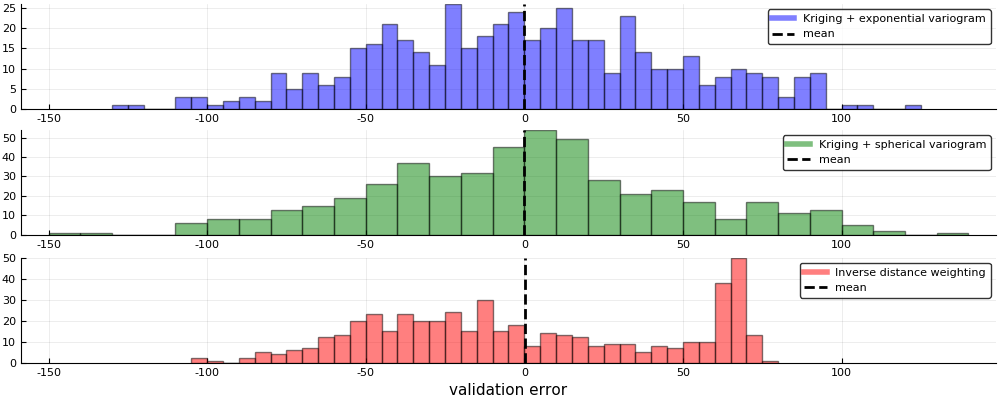

In [5]:
results = compare(solvers, problem, CrossValidation(10))

# get validation errors for porosity
errors = results[:porosity]

# plot error distribution for each solver
plt = plot(size=(1000,400), layout=(3,1), link=:x)

histogram!(plt[1], errors[1], bins=50, color=:blue, alpha=.5, label="Kriging + exponential variogram")
vline!(plt[1], [mean(errors[1])], color=:black, alpha=1., lw=2, ls=:dash, label="mean")

histogram!(plt[2], errors[2], bins=50, color=:green, alpha=.5, label="Kriging + spherical variogram")
vline!(plt[2], [mean(errors[2])], color=:black, alpha=1., lw=2, ls=:dash, label="mean")

histogram!(plt[3], errors[3], bins=50, color=:red, alpha=.5, label="Inverse distance weighting", xlab="validation error")
vline!(plt[3], [mean(errors[3])], color=:black, alpha=1., lw=2, ls=:dash, label="mean")

We verify the unbiasedness property of Kriging estimators (mean of errors is zero). We also stress that choosing a solver simply based on the mean absolute validation error is not a good idea. Although in this example, all the solvers present mean of errors around zero, inverse distance weighting is underestimating porosity values at many locations of the domain (see the mode in the right side of the distribution).